In [1]:
# For Caffe Models, we can directly use OpenCV method cv2.dnn.readNetFromCaffe() without having to use Keras
import numpy as np
import cv2
import io
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display

In [2]:
# Load preprocess and convert image to BLOB
# Load the image to detect, get width, height
# Convert to blob to pass into model
img_to_detect = cv2.imread('cv2-source-code/images/testing/scene5.jpg')
img_height = img_to_detect.shape[0]
img_width = img_to_detect.shape[1]

img_blob = cv2.dnn.blobFromImage(img_to_detect, swapRB=True, crop=False)
# recommended scale factor is 0.007843, width, height of blob is 300 x 300, mean of 255 is 127.5

In [3]:
# set of 90 class labels in predefined order
class_labels = ["person","bicycle","car","motorbike","aeroplane","bus","train","truck","boat","traffic light",
                "fire hydrant","street sign","stop sign","parking meter","bench","bird","cat","dog","horse",
                "sheep","cow","elephant","bear","zebra","giraffe","hat","backpack","umbrella","shoe","eye glasses",
                "handbag","tie","suitcase","frisbee","skis","snowboard","sports ball","kite","baseball bat","baseball glove",
                "skateboard","surfboard","tennis racket","bottle","plate","wine glass","cup","fork","knife",
                "spoon","bowl","banana","apple","sandwich","orange","broccoli","carrot","hot dog","pizza","donut",
                "cake","chair","sofa","pottedplant","bed","mirror","diningtable","window","desk","toilet","door","tv",
                "laptop","mouse","remote","keyboard","cell phone","microwave","oven","toaster","sink","refrigerator",
                "blender","book","clock","vase","scissors","teddy bear","hair drier","toothbrush"]

#Declare List of colors as an array
#Green, Blue, Red, cyan, yellow, purple
#Split based on ',' and for every split, change type to int
#convert that to a numpy array to apply color mask to the image numpy array
class_colors = ["0,255,0","0,0,255","255,0,0","255,255,0","0,255,255","255,0,255"]
class_colors = [np.array(every_color.split(",")).astype("int") for every_color in class_colors]
class_colors = np.array(class_colors)

In [4]:
# Load pre-trained model and get prediction
# loading pretrained model from protext and caffeodel files
# input preprocessed blob into model and pass through the model
# obtain the detection predictions by the model using forward() method
maskrcnn = cv2.dnn.readNetFromTensorflow('cv2-source-code/dataset/maskrcnn_buffermodel.pb', 'cv2-source-code/dataset/maskrcnn_bufferconfig.txt')
maskrcnn.setInput(img_blob)
(obj_detections_boxes, obj_detections_masks)  = maskrcnn.forward(["detection_out_final", "detection_masks"])
# returned obj_detections[0, 0, index, 1], 1 => will have the prediction lclass
# 2 => will have the confidence, 3 to 7 => will have the bounding box coordinates

In [5]:
# Loop over detections, get class label, box coordinates
# loop over the detections 
no_of_detections = obj_detections_boxes.shape[2]

for index in np.arange(0, no_of_detections):
  prediction_confidence = obj_detections_boxes[0, 0 , index, 2]
  # take only predictions with confidence more than 20%
  if prediction_confidence > 0.5:
    # get the prediction label
    predicted_class_index = int(obj_detections_boxes[0, 0, index, 1])
    predicted_class_label = class_labels[predicted_class_index]

    # obtain the bounding box coordinates for actual image from resized image size
    bounding_box = obj_detections_boxes[0, 0, index, 3:7] * np.array([img_width, img_height, img_width, img_height]) 
    (start_x_pt, start_y_pt, end_x_pt, end_y_pt) = bounding_box.astype("int")
    
    #obtain width and height of bounding box
    bounding_box_Width = end_x_pt - start_x_pt
    bounding_box_Height = end_y_pt - start_y_pt
    
    #obtain the bounding mask co-ordinates for currrent detection index
    object_mask = obj_detections_masks[index, predicted_class_index]

    #resize mask to bounding_box_Width and bounding_box_Height
    object_mask = cv2.resize(object_mask, (bounding_box_Width, bounding_box_Height))

    #minimum threshold value to convert float based mask array to binary 
    #if true respective values will be true and vice versa
    object_mask = (object_mask > 0.3)
    
    #slice the image array based on bounding box rectangle which is the roi
    object_region_of_interest = img_to_detect[start_y_pt:end_y_pt, start_x_pt:end_x_pt]
    #slice the roi array based on the bounding mask
    object_region_of_interest = object_region_of_interest[object_mask]

    #get a random mask color from the numpy array of colors
    mask_color = random.choice(class_colors)
    
    #add a transparent color cover to the region of interest
    roi_color_transparent_cover = ((0.3 * mask_color) + (0.5 * object_region_of_interest)).astype("uint8")
    #place the transparent color cover over the actual image
    img_to_detect[start_y_pt:end_y_pt, start_x_pt:end_x_pt][object_mask] = roi_color_transparent_cover

    #convert the color numpy array as a list and apply to text and box
    mask_color = [int(c) for c in mask_color]

    # print the prediction in ocnsole
    predicted_class_label = "{}: {:.2f}%".format(class_labels[predicted_class_index], prediction_confidence * 100)
    print("predicted object {}: {}".format(index+1, predicted_class_label))

    # Draw rectangle and text, display the image
    cv2.rectangle(img_to_detect, (start_x_pt, start_y_pt), (end_x_pt, end_y_pt), mask_color, 2)
    cv2.putText(img_to_detect, predicted_class_label, (start_x_pt, start_y_pt-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, mask_color, 1)

predicted object 1: boat: 99.35%
predicted object 2: boat: 98.73%
predicted object 3: boat: 98.67%
predicted object 4: boat: 77.87%


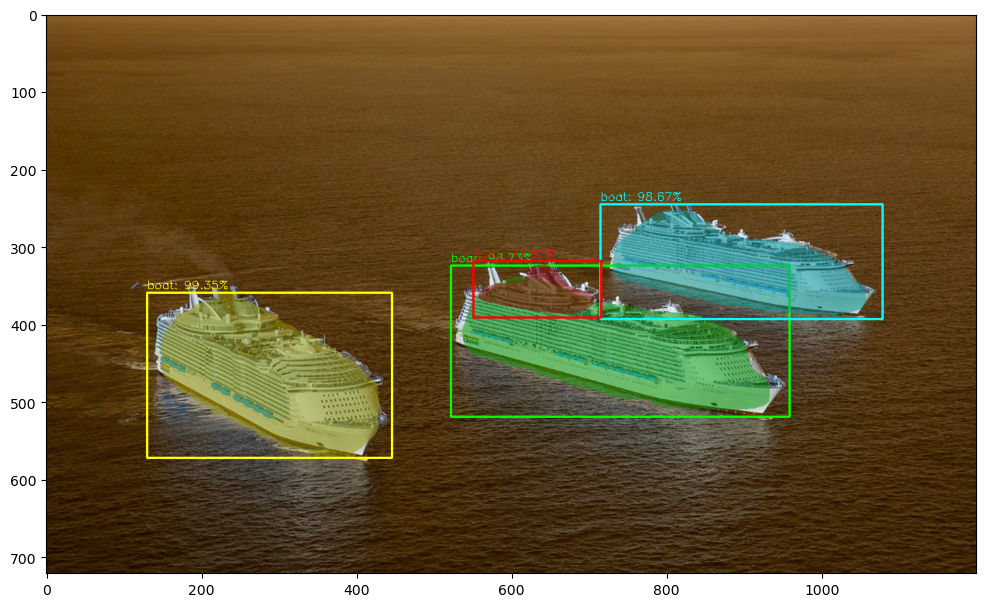

In [6]:
# show the output
# cv2.imshow("Detection Output", img_to_detect)
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img_to_detect)
plt.show()